Questões iniciais:

- Quais variáveis parecem ter relação com o diabetes?
- Há diferenças claras entre os grupos com e sem diabetes?
- Como variam IMC, sono, atividade física e saúde mental entre os grupos?

Agrupamento geral:

- O que caracteriza cada cluster? (média das variáveis)
- Como os clusters se relacionam com o risco de diabetes?
- Existe algum cluster com alta proporção de pré-diabéticos ou diabéticos?
- Quais características distinguem esse cluster
- As pessoas não-diabéticas nesse cluster estão em risco?

Agrupamento específico:

- Clusterização só em pessoas sem diabetes para encontrar grupos de risco ocultos
- Agrupar apenas por fatores modifícáveis (ex: exercício, alimentação, sono)

# Importação e Downloads

In [30]:
import pandas as pd
import glob
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gdown
import zipfile
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [31]:
file_id = "1FVuhmd_AxaeUabQxlJHVczhSaOSP4xof"

gdown.download(id=file_id, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1FVuhmd_AxaeUabQxlJHVczhSaOSP4xof
To: c:\diabetes-unsupervised-learning\diabetes_012_health_indicators_BRFSS2015.csv
100%|██████████| 22.7M/22.7M [00:05<00:00, 4.08MB/s]


'diabetes_012_health_indicators_BRFSS2015.csv'

In [32]:
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv', sep=',')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

# Agrupamento com K-Means

In [34]:
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


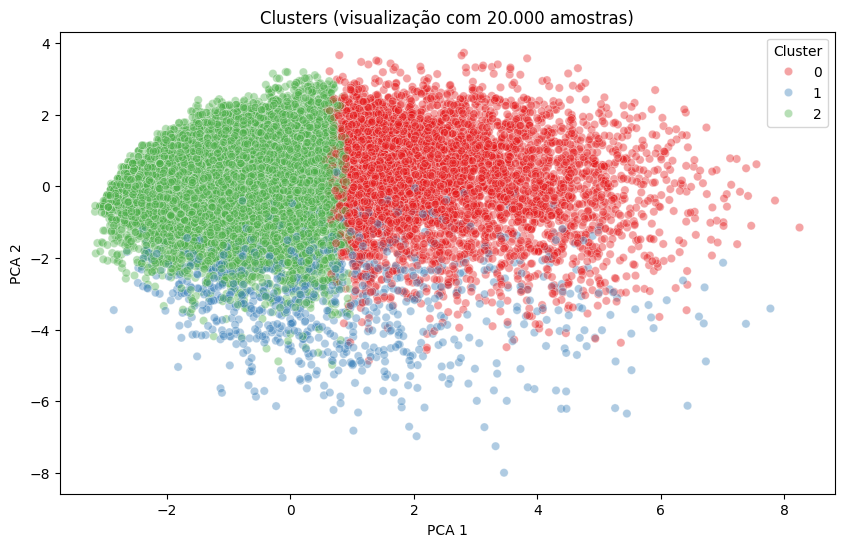

In [35]:
X = df.drop(columns=["Diabetes_012", "Sex"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_scaled)

cluster_means = df.groupby("Cluster")["Diabetes_012"].mean()

sorted_clusters = cluster_means.sort_values(ascending=False).index
cluster_map = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters)}

df["Cluster"] = df["Cluster"].map(cluster_map)

df_plot = pd.DataFrame({
    "PCA1": X_pca[:, 0],
    "PCA2": X_pca[:, 1],
    "Cluster": df["Cluster"],
    "Diabetes_012": df["Diabetes_012"]
})

df_sample = df_plot.sample(n=20000, random_state=42)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_sample, x="PCA1", y="PCA2", hue="Cluster", palette="Set1", alpha=0.4)
plt.title("Clusters (visualização com 20.000 amostras)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

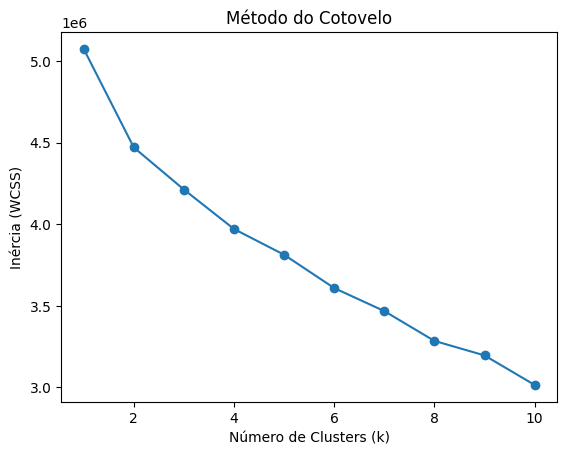

In [36]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (WCSS)')
plt.title('Método do Cotovelo')
plt.show()

In [37]:
# Ver média das variáveis por cluster
df.groupby("Cluster").mean().round(2)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.65,0.73,0.64,0.98,30.91,0.61,0.13,0.27,0.50,0.54,...,1.0,0.14,3.59,6.98,12.33,0.58,0.40,9.50,4.48,4.44
1,0.25,0.34,0.33,0.86,28.90,0.49,0.03,0.07,0.69,0.57,...,0.0,0.37,2.70,4.88,4.47,0.15,0.48,6.16,4.52,4.62
2,0.17,0.32,0.35,0.96,27.43,0.38,0.01,0.03,0.86,0.67,...,1.0,0.04,2.11,1.70,1.30,0.02,0.45,7.63,5.29,6.74


In [38]:
diabeticos = df[df['Diabetes_012'] == 2]
diabeticos.groupby("Diabetes_012").mean().round(2)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Cluster
Diabetes_012,,,,,,,,,,,,,,,,,,,,,
2.0,0.75,0.67,0.99,31.94,0.52,0.09,0.22,0.63,0.59,0.76,...,0.11,3.29,4.46,7.95,0.37,0.48,9.38,4.75,5.21,0.83


In [39]:
# Ver mediana das variáveis por cluster
df.groupby("Cluster").median().round(2)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.0,1.0,1.0,1.0,30.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,4.0,0.0,7.0,1.0,0.0,10.0,4.0,4.0
1,0.0,0.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,6.0,5.0,5.0
2,0.0,0.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,6.0,7.0


In [40]:
piores = df[df['Cluster'] == 0]
melhores = df[df['Cluster'] == 2]
medio = df[df['Cluster'] == 1]

In [41]:
piores['Diabetes_012'].value_counts(normalize=True)

Diabetes_012
0.0    0.657528
2.0    0.311120
1.0    0.031351
Name: proportion, dtype: float64

In [42]:
melhores['Diabetes_012'].value_counts(normalize=True)

Diabetes_012
0.0    0.907452
2.0    0.079169
1.0    0.013379
Name: proportion, dtype: float64

In [43]:
medio['Diabetes_012'].value_counts(normalize=True)

Diabetes_012
0.0    0.867028
2.0    0.112602
1.0    0.020370
Name: proportion, dtype: float64

In [44]:
melhores['Income'].value_counts(normalize=True)

Income
8.0    0.467133
7.0    0.197443
6.0    0.143723
5.0    0.083794
4.0    0.050549
3.0    0.030656
2.0    0.015066
1.0    0.011636
Name: proportion, dtype: float64

# Comparação entre Grupos de Risco e os Diabéticos

In [45]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
import pandas as pd

# 1. Definir variáveis para comparação (tirar colunas que não são atributos diretos)
variaveis = df.columns.drop(["Diabetes_012", "Sex", "Cluster"])

# 2. Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[variaveis])
df_scaled = pd.DataFrame(X_scaled, columns=variaveis, index=df.index)

# 3. Adicionar as colunas Diabetes e Cluster de volta
df_scaled["Diabetes_012"] = df["Diabetes_012"]
df_scaled["Cluster"] = df["Cluster"]

# 4. Calcular centroide dos diabéticos
centroide_diabeticos = df_scaled[df_scaled["Diabetes_012"] == 2][variaveis].mean()

# 5. Comparar todos os clusters com o centroide dos diabéticos
resultados = {}
for cluster_id in sorted(df_scaled["Cluster"].unique()):
    centroide_cluster = df_scaled[df_scaled["Cluster"] == cluster_id][variaveis].mean()
    distancia = euclidean(centroide_cluster, centroide_diabeticos)
    resultados[cluster_id] = distancia

# 6. Mostrar resultados
print("Distância Euclidiana entre cada cluster e o grupo de diabéticos:")
for cluster_id, distancia in resultados.items():
    print(f"Cluster {cluster_id}: {distancia:.2f}")

Distância Euclidiana entre cada cluster e o grupo de diabéticos:
Cluster 0: 1.13
Cluster 1: 5.00
Cluster 2: 2.61


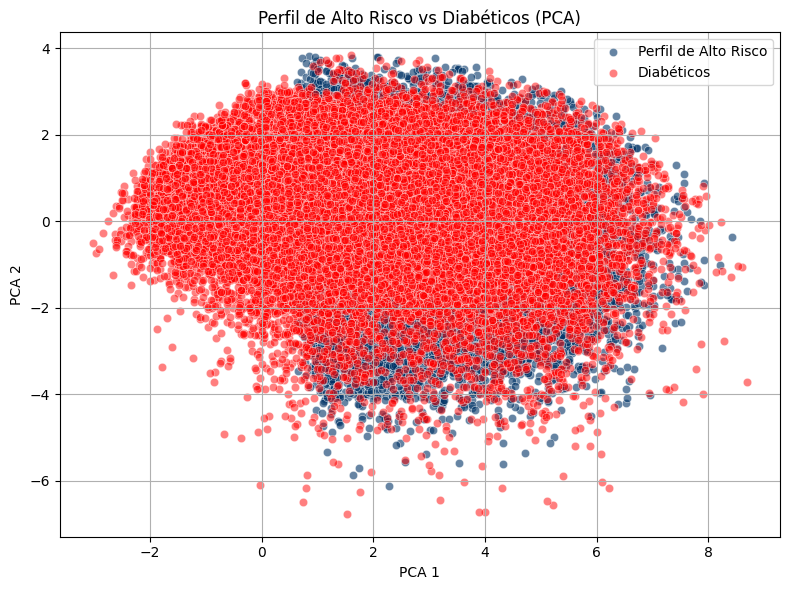

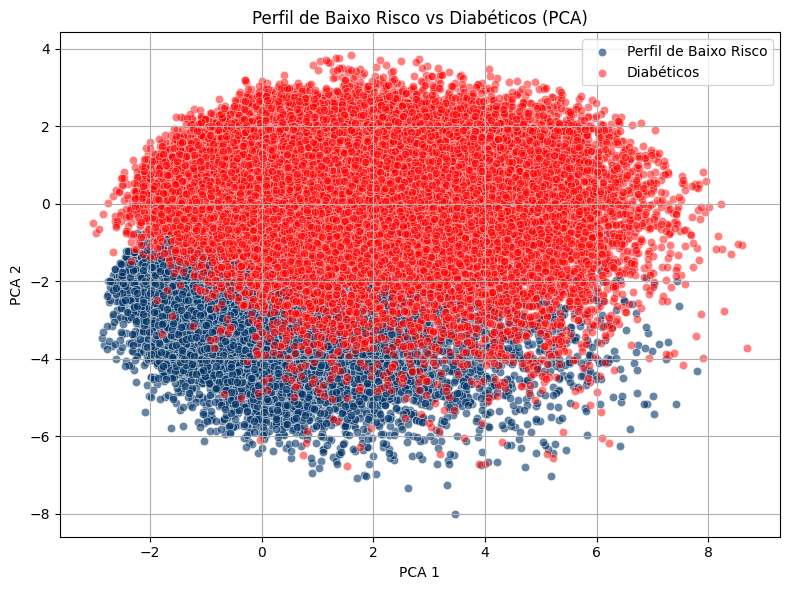

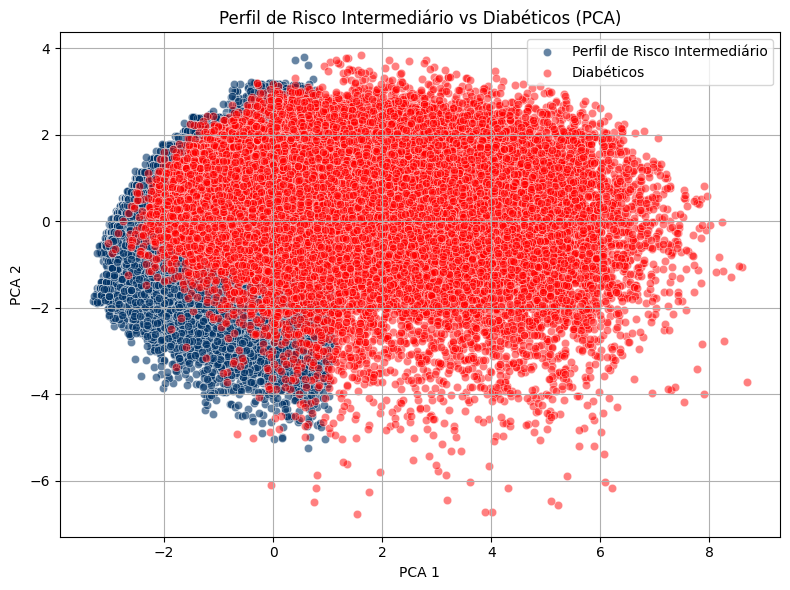

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# === 1. Selecionar colunas para padronizar (tirar variáveis não numéricas e alvo)
features = df.drop(columns=["Diabetes_012", "Sex", "Cluster"])  # manter apenas variáveis numéricas

# === 2. Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# === 3. Aplicar PCA (2 componentes)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# === 4. Adicionar os componentes PCA ao DataFrame original
df_pca = df.copy()
df_pca["PCA1"] = X_pca[:, 0]
df_pca["PCA2"] = X_pca[:, 1]

# === 5. Filtrar o grupo de diabéticos
diabeticos_pca = df_pca[df_pca["Diabetes_012"] == 2]

# === Dicionário para mapear cluster para nome de risco
cluster_names = {0: "Perfil de Alto Risco", 1: "Perfil de Baixo Risco", 2: "Perfil de Risco Intermediário"}

# === 6. Gerar gráficos por cluster com nomes e cor azul escuro para clusters
for cluster_id in sorted(df_pca["Cluster"].unique()):
    cluster = df_pca[(df_pca["Diabetes_012"] == 0) & (df_pca["Cluster"] == cluster_id)]
    cluster_name = cluster_names.get(cluster_id, f"Cluster {cluster_id}")

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=cluster, x="PCA1", y="PCA2",
        label=cluster_name,
        alpha=0.6,
        color="#003366"  # azul escuro
    )
    sns.scatterplot(
        data=diabeticos_pca, x="PCA1", y="PCA2",
        label="Diabéticos",
        alpha=0.5,
        color="red"
    )

    plt.title(f"{cluster_name} vs Diabéticos (PCA)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Risco de diabetes e questões sociais

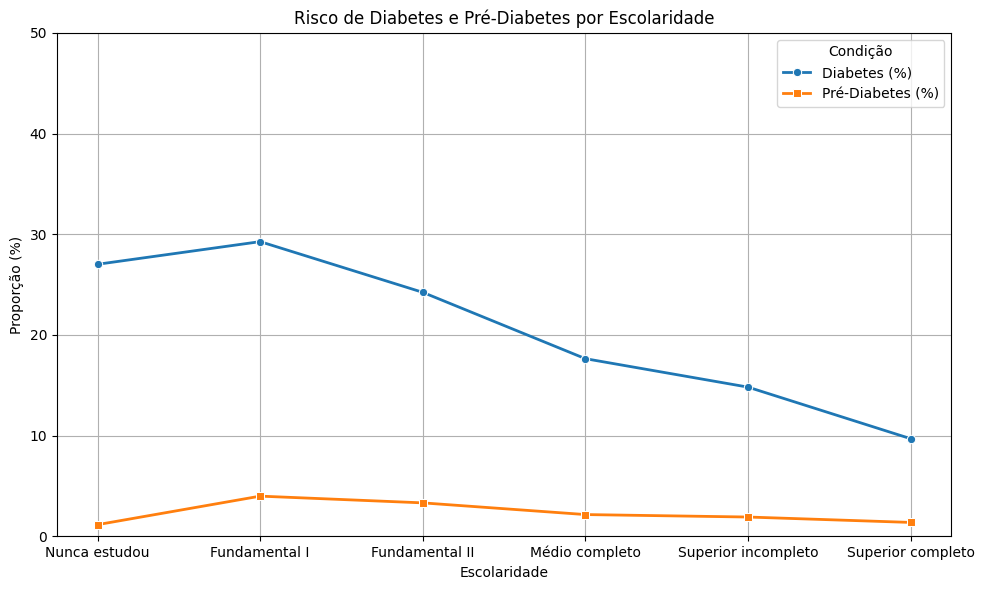

In [47]:
# Copiar o DataFrame
df_edu_risk = df.copy()

# Dicionário de rótulos de escolaridade
educ_labels = {
    1: "Nunca estudou", 2: "Fundamental I", 3: "Fundamental II",
    4: "Médio completo", 5: "Superior incompleto", 6: "Superior completo"
}

df_edu_risk["Educ_Label"] = df_edu_risk["Education"].map(educ_labels)

# Calcular proporções
diabetes_educ = df_edu_risk.groupby("Educ_Label")["Diabetes_012"].apply(lambda x: (x == 2).mean() * 100)
prediabetes_educ = df_edu_risk.groupby("Educ_Label")["Diabetes_012"].apply(lambda x: (x == 1).mean() * 100)

# Ordenar corretamente
ordered_educ = list(educ_labels.values())
diabetes_educ = diabetes_educ.reindex(ordered_educ)
prediabetes_educ = prediabetes_educ.reindex(ordered_educ)

# Plotar
plt.figure(figsize=(10, 6))
sns.lineplot(x=diabetes_educ.index, y=diabetes_educ.values, marker='o', label="Diabetes (%)", linewidth=2)
sns.lineplot(x=prediabetes_educ.index, y=prediabetes_educ.values, marker='s', label="Pré-Diabetes (%)", linewidth=2)

plt.title("Risco de Diabetes e Pré-Diabetes por Escolaridade")
plt.xlabel("Escolaridade")
plt.ylabel("Proporção (%)")
plt.ylim(0, 50)
plt.grid(True)
plt.legend(title="Condição", loc="upper right")
plt.tight_layout()
plt.show()

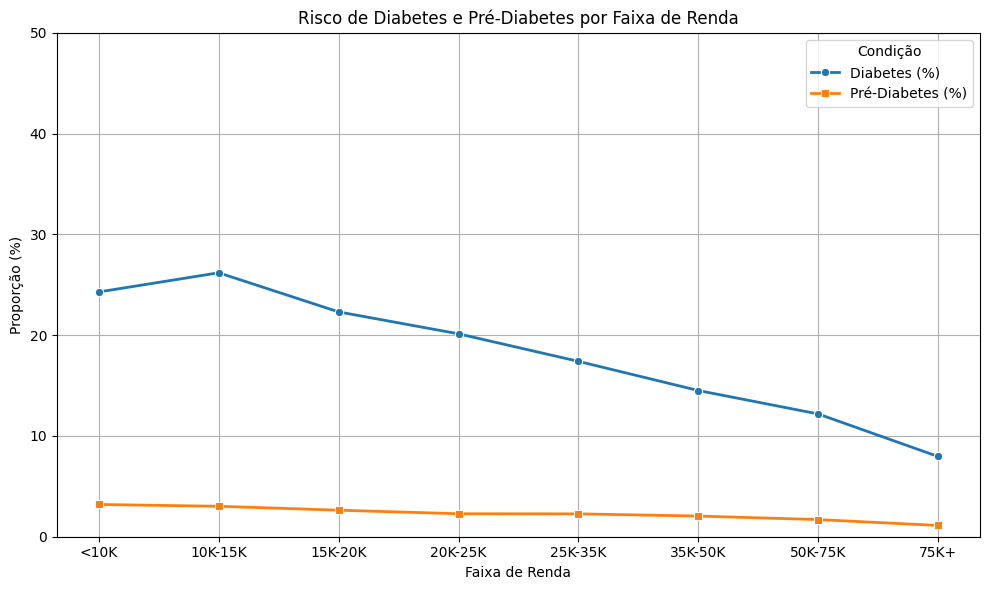

In [48]:
# Copiar o DataFrame
df_renda_risk = df.copy()

# Dicionário de rótulos de renda
renda_labels = {
    1: "<10K", 2: "10K-15K", 3: "15K-20K", 4: "20K-25K",
    5: "25K-35K", 6: "35K-50K", 7: "50K-75K", 8: "75K+"
}

df_renda_risk["Renda_Label"] = df_renda_risk["Income"].map(renda_labels)

# Calcular proporções
diabetes_renda = df_renda_risk.groupby("Renda_Label")["Diabetes_012"].apply(lambda x: (x == 2).mean() * 100)
prediabetes_renda = df_renda_risk.groupby("Renda_Label")["Diabetes_012"].apply(lambda x: (x == 1).mean() * 100)

# Manter a ordem original
ordered_labels = list(renda_labels.values())
diabetes_renda = diabetes_renda.reindex(ordered_labels)
prediabetes_renda = prediabetes_renda.reindex(ordered_labels)

# Plotar
plt.figure(figsize=(10, 6))
sns.lineplot(x=diabetes_renda.index, y=diabetes_renda.values, marker='o', label="Diabetes (%)", linewidth=2)
sns.lineplot(x=prediabetes_renda.index, y=prediabetes_renda.values, marker='s', label="Pré-Diabetes (%)", linewidth=2)

plt.title("Risco de Diabetes e Pré-Diabetes por Faixa de Renda")
plt.xlabel("Faixa de Renda")
plt.ylabel("Proporção (%)")
plt.ylim(0, 50)
plt.grid(True)
plt.legend(title="Condição", loc="upper right")
plt.tight_layout()
plt.show()

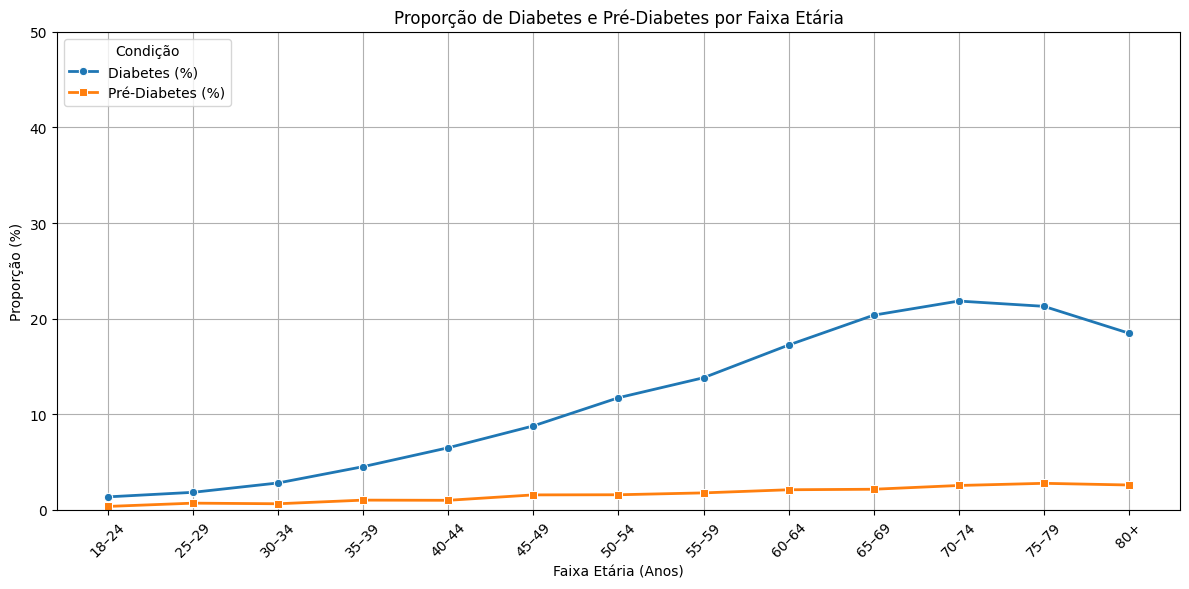

In [49]:
# Cópia do DataFrame
df_age_risk = df.copy()

# Mapeamento de códigos para rótulos de faixa etária
age_labels = {
    1: '18–24',
    2: '25–29',
    3: '30–34',
    4: '35–39',
    5: '40–44',
    6: '45–49',
    7: '50–54',
    8: '55–59',
    9: '60–64',
    10: '65–69',
    11: '70–74',
    12: '75–79',
    13: '80+'
}
df_age_risk["Faixa_Idade"] = df_age_risk["Age"].map(age_labels)

# Calcular proporções de diabetes e pré-diabetes
diabetes_pct = (
    df_age_risk.groupby("Faixa_Idade")["Diabetes_012"]
    .apply(lambda x: (x == 2).mean() * 100)
    .reindex(age_labels.values())
)

prediabetes_pct = (
    df_age_risk.groupby("Faixa_Idade")["Diabetes_012"]
    .apply(lambda x: (x == 1).mean() * 100)
    .reindex(age_labels.values())
)

# Plotar
plt.figure(figsize=(12, 6))
sns.lineplot(x=diabetes_pct.index, y=diabetes_pct.values, marker='o', label='Diabetes (%)', linewidth=2)
sns.lineplot(x=prediabetes_pct.index, y=prediabetes_pct.values, marker='s', label='Pré-Diabetes (%)', linewidth=2)

plt.title("Proporção de Diabetes e Pré-Diabetes por Faixa Etária")
plt.xlabel("Faixa Etária (Anos)")
plt.ylabel("Proporção (%)")
plt.ylim(0, 50)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Condição", loc="upper left")
plt.tight_layout()
plt.show()

C:\Users\bcbru\AppData\Local\Temp\ipykernel_3256\1922543635.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_bmi_risk.groupby("BMI_Faixa")["Diabetes_012"]
C:\Users\bcbru\AppData\Local\Temp\ipykernel_3256\1922543635.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_bmi_risk.groupby("BMI_Faixa")["Diabetes_012"]


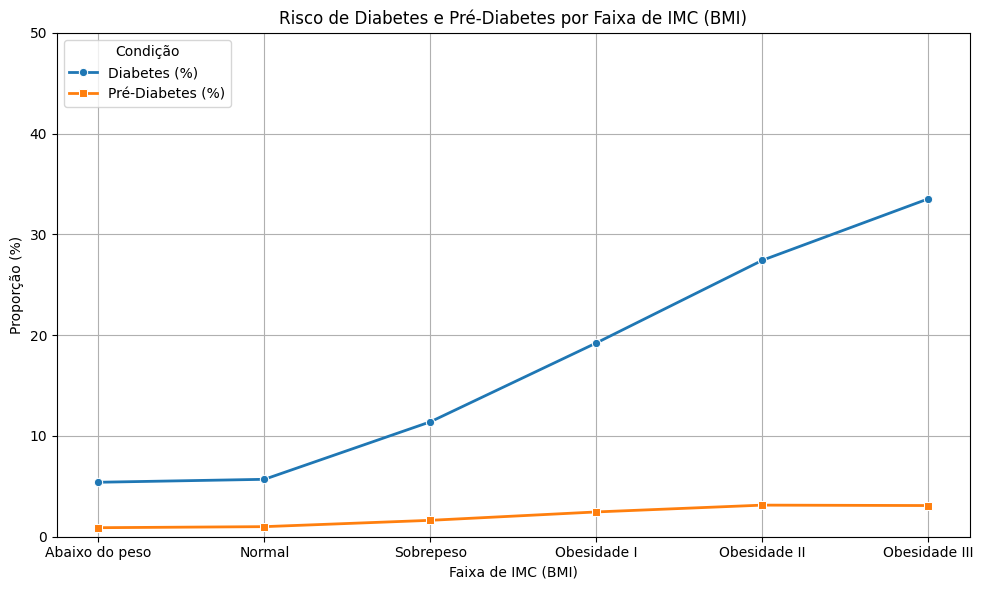

In [50]:
# Copiar o dataframe original
df_bmi_risk = df.copy()

# Criar faixas de BMI
bins = [0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')]
labels = ['Abaixo do peso', 'Normal', 'Sobrepeso', 'Obesidade I', 'Obesidade II', 'Obesidade III']
df_bmi_risk["BMI_Faixa"] = pd.cut(df_bmi_risk["BMI"], bins=bins, labels=labels)

# Calcular porcentagens por faixa de BMI
diabetes_por_faixa = (
    df_bmi_risk.groupby("BMI_Faixa")["Diabetes_012"]
    .apply(lambda x: (x == 2).mean() * 100)
    .reindex(labels)
)

prediabetes_por_faixa = (
    df_bmi_risk.groupby("BMI_Faixa")["Diabetes_012"]
    .apply(lambda x: (x == 1).mean() * 100)
    .reindex(labels)
)

# Plotar o gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(
    x=diabetes_por_faixa.index,
    y=diabetes_por_faixa.values,
    marker='o',
    linewidth=2,
    label="Diabetes (%)"
)
sns.lineplot(
    x=prediabetes_por_faixa.index,
    y=prediabetes_por_faixa.values,
    marker='s',
    linewidth=2,
    label="Pré-Diabetes (%)"
)

plt.title("Risco de Diabetes e Pré-Diabetes por Faixa de IMC (BMI)")
plt.xlabel("Faixa de IMC (BMI)")
plt.ylabel("Proporção (%)")
plt.ylim(0, 50)
plt.grid(True)
plt.legend(title="Condição", loc="upper left")
plt.tight_layout()
plt.show()

In [51]:
diff = df_bmi_risk[(df_bmi_risk['BMI_Faixa'] == 'Obesidade III') & (df_bmi_risk['DiffWalk'] == 1) & (df_bmi_risk['HeartDiseaseorAttack'] == 1)]

In [52]:
diff['Diabetes_012'].value_counts(normalize=True)

Diabetes_012
2.0    0.611251
0.0    0.368598
1.0    0.020151
Name: proportion, dtype: float64